In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm 

import torch 
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

torch.manual_seed(42)

In [2]:
# import data
df_species = pd.read_parquet('../processed_data/species_coverage.parquet')

df_genes   = pd.read_parquet('../processed_data/gene_coverage.parquet')
df_genes = df_genes.set_index("Sample")

# match indexes
df_species = df_species.reindex(df_genes.index)

# Data Processing

In [3]:
count_species = (df_species > 0).sum(0)
count_genes = (df_genes > 0).sum(0)

# remove columns that rarely show up
threshold = 200

species_keep = count_species[count_species >= threshold].index
genes_keep = count_genes[count_genes >= threshold].index

df_species = df_species[species_keep]
df_genes = df_genes[genes_keep]

del species_keep
del genes_keep

# Logistic Regression

In [4]:
# convert genes to binary for logistic regression
df_genes_binary = (df_genes > 0).astype(int)

del df_genes

In [5]:
# for future reference
species_names = df_species.columns.tolist()
gene_names = df_genes_binary.columns.tolist()

#  -- tensors --
X = torch.tensor(df_species.values, dtype=torch.float32)  # Species as input
y = torch.tensor(df_genes_binary.values, dtype=torch.float32)  # Genes as output

# train val test split
total_samples = X.shape[0]
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size  # Ensures all samples are used

indices = torch.randperm(total_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

# -- datasets and loaders --
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# If GPU is available, use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [7]:
input_size = X.shape[1]  # Number of species
output_size = y.shape[1] # Number of genes
model = LogisticRegressionModel(input_size, output_size).to(device)

# loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# train loop
epochs = 5
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # val
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    # average val loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/5], Train Loss: 6.2792, Val Loss: 3.7573
Epoch [2/5], Train Loss: 3.4773, Val Loss: 3.3618
Epoch [3/5], Train Loss: 3.1953, Val Loss: 3.3747
Epoch [4/5], Train Loss: 3.1350, Val Loss: 3.4024
Epoch [5/5], Train Loss: 3.1608, Val Loss: 3.3237


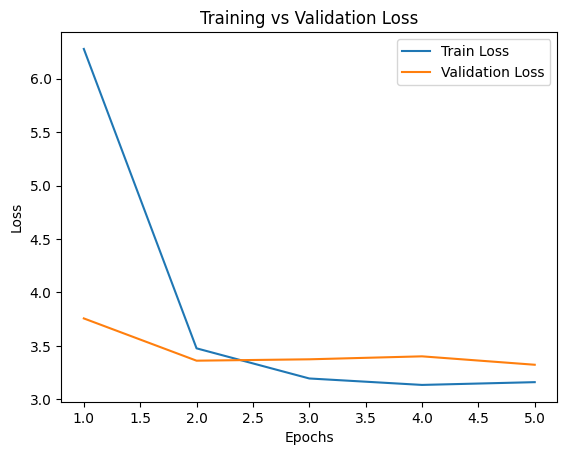

In [8]:
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Model Analysis

In [14]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in tqdm(test_loader, desc='evaluating'):
        outputs = model(batch_X)
        all_preds.append(outputs)
        all_labels.append(batch_y)

# concatenate batches
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# convert tensors to numpy arrays
all_preds = all_preds.cpu().numpy()
all_labels = all_labels.cpu().numpy()

# apply threshold of 0.5 to get binary predictions
predictions = (all_preds >= 0.5).astype(int)

# number of independent logistic regressions (outputs)
num_outputs = predictions.shape[1]

def compute_metrics(i):
    y_true = all_labels[:, i]
    y_pred = predictions[:, i]
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1_val = f1_score(y_true, y_pred, zero_division=0)
    if len(np.unique(y_true)) > 1:
        auc = roc_auc_score(y_true, all_preds[:, i])
    else:
        auc = np.nan
    return (acc, prec, rec, f1_val, auc)

# chunked parallel approach
results = []
chunk_size = 100  # solution to display the progress bar on jupyter notebook
with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
    for res in tqdm(executor.map(compute_metrics, range(num_outputs), chunksize=chunk_size),
                    total=num_outputs, desc='computing metrics'):
        results.append(res)

accuracies, precisions, recalls, f1s, roc_aucs = map(list, zip(*results))

evaluating: 100%|████████████| 9/9 [00:01<00:00,  8.55it/s]
computing metrics: 100%|█| 255201/255201 [13:56<00:00, 305.


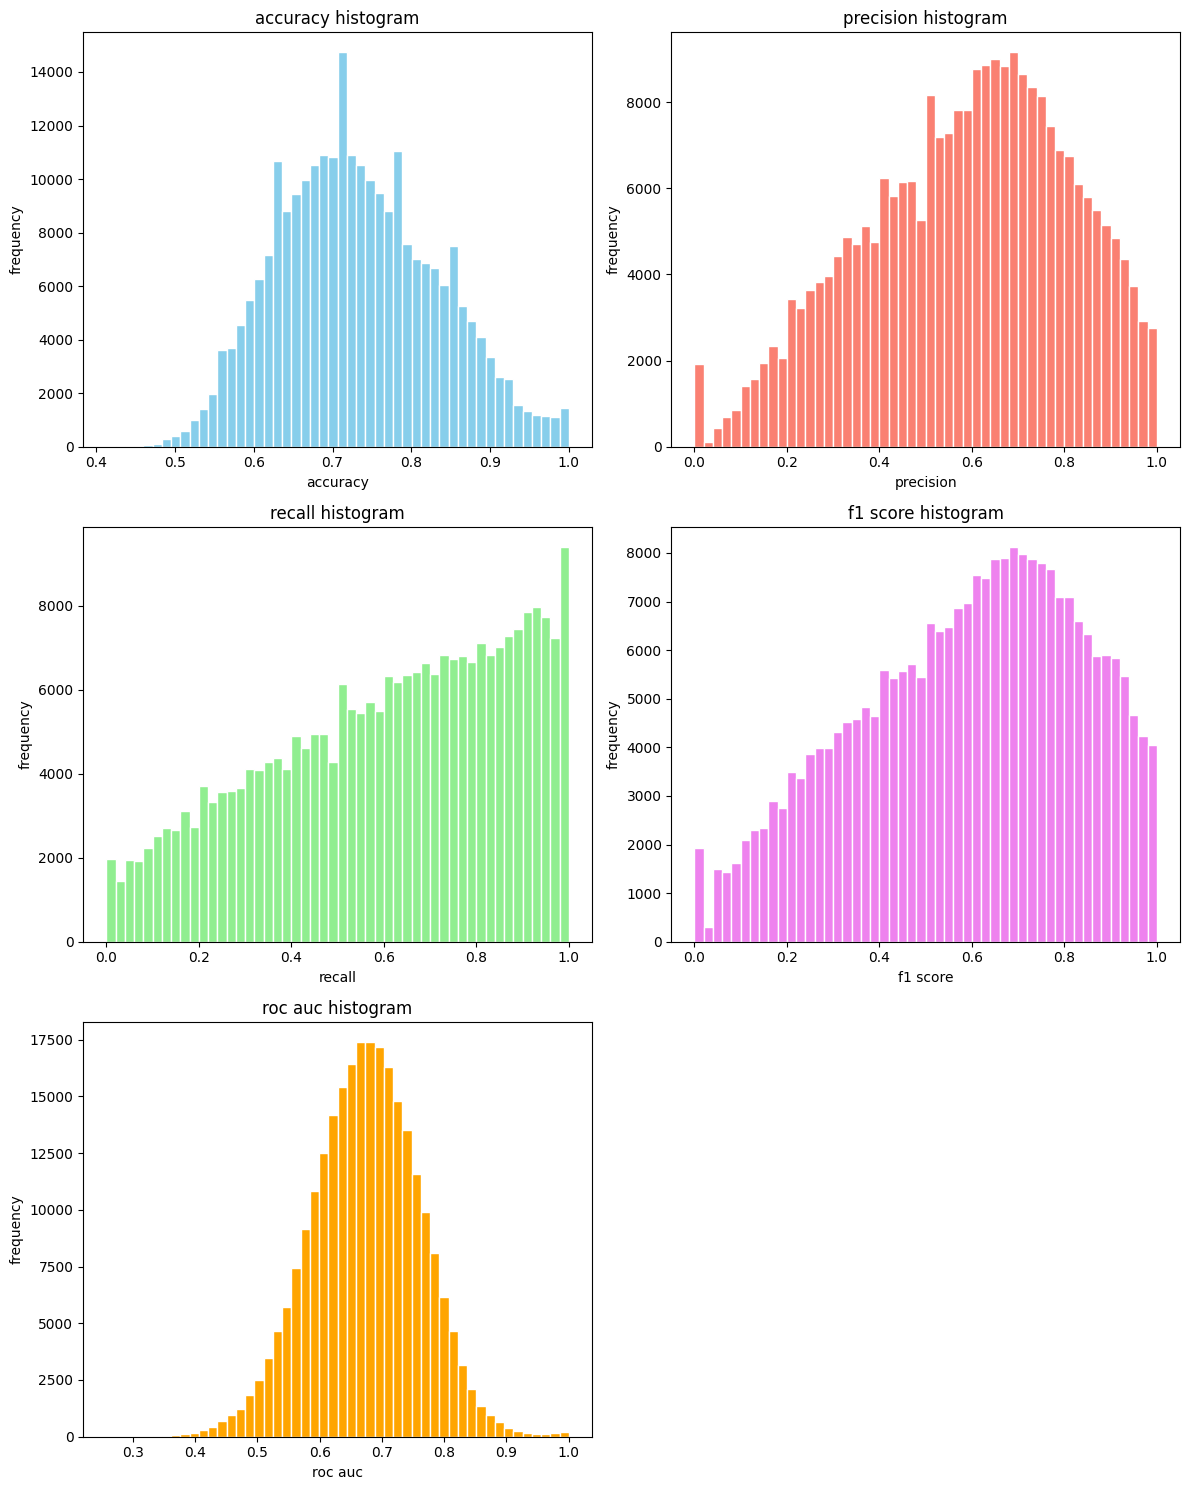

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

bins = 50

axs[0, 0].hist(accuracies, bins=bins, color='skyblue', edgecolor='white')
axs[0, 0].set_title('accuracy histogram')
axs[0, 0].set_xlabel('accuracy')
axs[0, 0].set_ylabel('frequency')

axs[0, 1].hist(precisions, bins=bins, color='salmon', edgecolor='white')
axs[0, 1].set_title('precision histogram')
axs[0, 1].set_xlabel('precision')
axs[0, 1].set_ylabel('frequency')

axs[1, 0].hist(recalls, bins=bins, color='lightgreen', edgecolor='white')
axs[1, 0].set_title('recall histogram')
axs[1, 0].set_xlabel('recall')
axs[1, 0].set_ylabel('frequency')

axs[1, 1].hist(f1s, bins=bins, color='violet', edgecolor='white')
axs[1, 1].set_title('f1 score histogram')
axs[1, 1].set_xlabel('f1 score')
axs[1, 1].set_ylabel('frequency')

axs[2, 0].hist(roc_aucs, bins=bins, color='orange', edgecolor='white')
axs[2, 0].set_title('roc auc histogram')
axs[2, 0].set_xlabel('roc auc')
axs[2, 0].set_ylabel('frequency')

axs[2, 1].axis('off')

plt.tight_layout()
plt.show()

Below is a brief interpretation of each histogram and some overall observations about the results:

**Accuracy**

The histogram peaks around 0.6–0.7.
This indicates that, for a large subset of genes, the model’s prediction accuracy is in this moderate range.
There is a trailing group that achieves higher accuracy (close to 1.0), and a smaller group with lower accuracy (around 0.4–0.5).

**Precision**

Most values center roughly in the 0.4–0.8 range, with a notable tail towards lower precision (0.0–0.2).
This suggests that while many genes are predicted with decent precision, some are predicted poorly (potentially due to class imbalance or difficulty in distinguishing positives from negatives).

**Recall**

The distribution skews toward the higher end (many genes’ recall is in the 0.7–1.0 range), although the histogram extends down to near 0.0.
Overall, it seems that, on average, the model is capturing quite a few true positives for many genes, but there are also genes for which recall is very low.

**F1 Score**

The F1 distribution is somewhat broad, peaking around 0.5–0.6.
The F1 score combines precision and recall, so it being somewhat lower than recall alone suggests that precision might be a limiting factor for many genes.

**ROC AUC**

Peaks around 0.7 but extends from ~0.3 or 0.4 up to near 1.0.
An AUC of ~0.7 typically indicates moderate discriminative ability on average. Some genes are very well modeled (high AUC close to 1.0), while others are closer to random (0.5) or below.
Overall Observations
Wide Variation in Performance:
The histograms show a fairly broad range of performance across different genes. Some genes are modeled quite well (high accuracy, precision, recall, etc.), while others are not.

**Higher Recall Than Precision for Many Genes:**
The recall distribution skews higher than the precision distribution. This often happens if the model is more sensitive (it detects more positives) but at the cost of labeling more negatives as positives, reducing precision.

**Moderate AUC (~0.7)**
The ROC AUC distribution centered around 0.7 suggests that, on average, the model provides a reasonable level of discrimination. However, the spread implies that some genes are harder to classify than others.

**Potential Next Steps:**

- Check for Class Imbalances: Particularly for those genes with very low precision or very low recall, there might be significant class imbalance.

- Hyperparameter Tuning: Adjusting learning rate, batch size, or regularization might improve overall performance.

- Feature Engineering or Model Changes: If certain genes are persistently poorly predicted, you could investigate whether additional features or a different model architecture might help.

  
In short, these distributions show that the model is performing moderately well on average but that substantial variability exists across individual genes. Analyzing those genes with the worst metrics (and perhaps those with the best) will likely give insight into how to improve the model further.